In [1]:
import pandas as pd
import numpy as np

import string
import nltk
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import cosine_sim ## This only for testing


In [2]:
df_isp_irc = pd.read_excel('vt_isp_irc.xlsx')
df_isp_task = pd.read_excel('vt_isp_task_mhrs.xlsx')
df_isp_material = pd.read_excel('vt_isp_material_consumption_pricing.xlsx')

df_isq_irc = pd.read_excel('vt_isq_irc.xlsx')
df_isq_task = pd.read_excel('vt_isq_task_mhrs.xlsx')
df_isq_material = pd.read_excel('vt_isq_material_consumption_pricing.xlsx')

df_iux_irc = pd.read_excel('vt_iux_irc.xlsx')
df_iux_task = pd.read_excel('vt_iux_task_mhrs.xlsx')
df_iux_material = pd.read_excel('vt_iux_material_consumption_pricing.xlsx')

In [3]:
df_isp_irc.head(2)                                                                                                            

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000059/0923/1,53,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...,HMV23/000059/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000059/0923/2,34,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...,HMV23/000059/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Fields to consider in 'VT ISP IRC'
- Planned Start Date
- Planned End Date
- Actual Start Date
- Actual End Date
- Est. Man Hrs.
- Actual Man Hrs.
- Insp Req?
- Mech Req?
- Part Required?
- Contract Classification
- Source Task/Discrep. #
- Description
- Corrective Action
- Log Item #

In [4]:
df_isq_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000055/0923/1,57,"DURING ARRIVAL INSPECTION , OBSERVED DENT ON S...",REFER SDIRC HMV23/000055/0923/7 FOR REPAIR DET...,HMV23/000055/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000055/0923/2,53,DURING INSPECTION OBSERVED LH WING SLAT#5 WEAT...,CARRIED OUT INSTALLATION OF LH WING SLAT #5 OU...,HMV23/000055/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


In [5]:
df_iux_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000043/0823/1,33,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1. RH NAV POSITION LIGHT TROUBLESHOOTING CARRI...,HMV23/000043/0823/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000043/0823/2,25,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1.FWD AND AFT WALL MOUNTED CABIN ATTENDENT SEA...,HMV23/000043/0823/2,Close,Closed,AWR23/002577/0823,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Tokenize and embed the descriptions of unexpected observations made.

In [6]:
# Download NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ranjith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ranjith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ranjith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Load spacy en_core_web_sm model
nlp = spacy.load("en_core_web_sm")

In [8]:
def preprocess_text(text: str, preserve_symbols=[], words_to_remove=['DURING', 'INSPECTION', 'OBSERVED']) -> str:
    '''
    This function performs text preprocessing and returns processed text. 
    It will also accept a list of symbols to preserve.
    Input: text
    Output: text
    '''
    # Define symbols to preserve
    preserve_symbols = set(preserve_symbols)

    for word in words_to_remove:
        text = text.replace(word, ' ')
    
    # Remove punctuation, excluding specified symbols
    custom_translation = str.maketrans('', '', ''.join(set(string.punctuation) - preserve_symbols))
    text = text.translate(custom_translation)
    return text


def tokenization(preprocessed_text: str) -> list:
    '''
    This function performs text tokenization and returns a list of tokens.
    Input: text
    Output: list of tokens
    '''
    sentences = sent_tokenize(preprocessed_text)
    preprocessed_tokens = []

    # Tokenization and stopword removal
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.lower() not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        preprocessed_tokens.append(tokens)

    return preprocessed_tokens


def calculate_embeddings(preprocessed_tokens: list) -> list:
    '''
    This function performs text embedding and returns a list of embeddings.
    Input: list of tokens
    Output: list of embeddings
    '''
    # Embedding
    embeddings = []
    for token in preprocessed_tokens:
        sentence = ' '.join(token)
        doc = nlp(sentence)
        sentence_embedding = doc.vector
        embeddings.append(sentence_embedding)

    return embeddings


def main(text: str, preserve_symbols=['-', '/']) -> list:
    '''
    This function performs text preprocessing, tokenization, embedding and returns a list of embeddings.
    Input: text
    Output: list of embeddings
    '''
    preprocessed_text = preprocess_text(text, preserve_symbols)
    preprocessed_tokens = tokenization(preprocessed_text)
    embeddings = calculate_embeddings(preprocessed_tokens)

    return embeddings

In [9]:
df_isp_irc.groupby(by='Source Task/Discrep. #').get_group('AIRCRAFT ARRIVAL INSPECTION')['Description'].tolist()

['1. DURING INSPECTION OBERVED LH WING SLATE #01, TRACK#02 ,#03, #04 UPPER BULB SEAL DAMAGE.SAME TO BE REPLACED.\n\n2. DURING INSPECTION OBSERVED SLAT#02 TRACK #5 PLATE DAMAGE.SAME TO BE REPLACED.',
 'DURING ARRIVAL INSPECTION CHECK FOUND FAILURE MESSAGE IN PFR " NO ADF 1 DATA (INTM) ".',
 'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.',
 'DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION \n1.103VU BATTERY COMPARMENT LAMP FIN: 8LS QTY#1,.\n2. REFUEL/DEFUEL CONTROL PANEL FLOODLIGHT LAMP FIN: 32QU.',
 'DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS DICREPANCIES.\n\n1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL DEGRADED.\n2) RH SIIDE WING SLAT NO#5 OUT BOARD WEATHER SEAL ERODED. SAME TO BE REPLACED.',
 'DURING INSPECTION FOUND FOLLOWING

### ISP

In [10]:
grouped_df_Description = df_isp_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_isp_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_isp_irc['description_correction'] = df_isp_irc['Description'] +' '+df_isp_irc['Corrective Action']
grouped_df_description_correction = df_isp_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [11]:
grouped_df_Description

Source Task/Discrep. #         
215222-01-1 (LH)             9     [[-0.5932818, -0.0010883957, -0.05046092, -0.4...
                             12    [[-0.78071886, -0.16903323, 0.12170592, 0.2050...
252100-01-1                  16    [[-0.6071717, -0.045728896, -0.14002277, 0.403...
384241-01-1                  11    [[-0.29012585, -0.25208855, 0.40247178, 0.6032...
531900-03-1                  10    [[-0.5505584, -0.4116526, 0.38711795, 0.066678...
AIRCRAFT ARRIVAL INSPECTION  0     [[-0.62076557, -0.2706989, -0.30009857, 0.5027...
                             1     [[-0.42883492, -0.2616663, -0.093726, 0.251545...
                             2     [[-0.29356578, -0.25122398, -0.45151266, 0.281...
                             3     [[-0.56311464, -0.36715958, -0.12396865, 0.070...
                             4     [[-0.36069342, -0.4691468, -0.3341932, 0.42472...
                             5     [[-0.4279495, -0.52520716, 0.31095126, 0.21888...
                             6   

In [12]:
df_isp_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_isp_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_isp_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [13]:
df_isp_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...,"[-0.5932818, -0.0010883957, -0.05046092, -0.42...","[-0.7883508, -0.48455766, 0.053018823, 0.28613...","[-0.7137893, -0.31926173, 0.0778499, 0.1309406..."
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...,"[-0.78071886, -0.16903323, 0.12170592, 0.20508...","[-0.81899613, -0.536668, 0.20998687, 0.4754251...","[-0.78071094, -0.45287976, 0.18304262, 0.43242..."
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...,STATIC DISCHARGERS REPLACED AT FOLLOWING LOCAT...,"[-0.6071717, -0.045728896, -0.14002277, 0.4039...","[-0.6302614, -0.56779945, 0.33402082, 0.639082...","[-0.615419, -0.4188404, 0.1845404, 0.5690741, ..."
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...,1. CARRIED OUT REPLACEMENT OF SERVICE LIGHT LA...,"[-0.29012585, -0.25208855, 0.40247178, 0.60321...","[-0.7275441, -0.58689135, 0.39343697, 0.385342...","[-0.60361254, -0.4998841, 0.3274086, 0.4429302..."
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS...","1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SE...","[-0.5505584, -0.4116526, 0.38711795, 0.0666788...","[-0.7171926, -0.6179478, 0.64386773, 0.5765455...","[-0.647318, -0.551189, 0.59292305, 0.43027005,..."


### ISQ

In [14]:
grouped_df_Description = df_isq_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_isq_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_isq_irc['description_correction'] = df_isq_irc['Description'] +' '+df_isq_irc['Corrective Action']
grouped_df_description_correction = df_isq_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [15]:
df_isq_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_isq_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_isq_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [16]:
df_isq_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000055/0923/1,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED DENT ON S...",REFER SDIRC HMV23/000055/0923/7 FOR REPAIR DET...,"[-0.67295957, -0.23972516, 0.33693656, -0.1447...","[-0.7295349, -0.713442, 0.51912445, 0.39860415...","[-0.6905092, -0.5997113, 0.43819317, 0.3385289..."
1,HMV23/000055/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING INSPECTION OBSERVED LH WING SLAT#5 WEAT...,CARRIED OUT INSTALLATION OF LH WING SLAT #5 OU...,"[-0.41807544, -0.16622221, -0.1757603, -0.4937...","[-0.7883508, -0.48455766, 0.053018823, 0.28613...","[-0.65773445, -0.37210473, 0.037761584, 0.1100..."
2,HMV23/000055/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING WARN...,NO FAILURE MSG RELATED TO WARNING MSG FOUND IN...,"[-0.60074383, -0.04490112, -0.11507999, 0.4059...","[-0.6249028, -0.57243884, 0.30982047, 0.613955...","[-0.6101982, -0.42633343, 0.17846772, 0.553590..."
3,HMV23/000055/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING FAIL...,T/S CARRIED OUT AS PER TSM 34-53-00-810-801-A ...,"[-0.5449455, -0.31652254, 0.52052444, 0.425085...","[-0.64926, -0.50040424, 0.51414716, 0.3555005,...","[-0.60519946, -0.42529154, 0.50889045, 0.36947..."
4,HMV23/000055/0923/5,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING FAIL...,CARRIED OUT TROUBLESHOOTING IAW TSM 38-31-00-8...,"[-0.59758735, -0.542203, 0.3808793, 0.36419034...","[-0.7275441, -0.58689135, 0.39343697, 0.385342...","[-0.6360664, -0.58385664, 0.46718067, 0.397149..."


### IUX

In [17]:
grouped_df_Description = df_iux_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_iux_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_iux_irc['description_correction'] = df_iux_irc['Description'] +' '+df_iux_irc['Corrective Action']
grouped_df_description_correction = df_iux_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [18]:
df_iux_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_iux_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_iux_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [19]:
df_iux_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000043/0823/1,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1. RH NAV POSITION LIGHT TROUBLESHOOTING CARRI...,"[-0.23691127, -0.4796934, -0.5459764, 0.477071...","[-0.7106022, -0.6184002, 0.35787284, 0.6952081...","[-0.56294733, -0.5443227, 0.1083702, 0.6183946..."
1,HMV23/000043/0823/2,AWR23/002577/0823,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1.FWD AND AFT WALL MOUNTED CABIN ATTENDENT SEA...,"[-0.3478613, -0.29101002, -0.25923744, 0.44358...","[-0.6923184, -0.63432103, 0.34662333, 0.576541...","[-0.6366421, -0.5740017, 0.24087797, 0.5519692..."
2,HMV23/000043/0823/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED DELAMINATIO...,"1)REMOVED FWD CARGO FLOOR PANEL 131AF,131EF,13...","[-0.5547514, -0.13354568, -0.3286858, 0.277467...","[-0.56586736, -0.6120607, 0.27154183, 0.528793...","[-0.5608442, -0.45788246, 0.10797499, 0.446444..."
3,HMV23/000043/0823/4,WEAR LIMITS- BONDING LEADS,"DURING PHYSICAL INSPECTION OF BONDING LEADS, O...",BONDING JUMPERS AT FOLLOWING LOCATIONS REPLACE...,"[-0.5789655, -0.13059905, -0.27789873, 0.14338...","[-0.5551411, -0.48651224, 0.18812323, 0.516921...","[-0.5641579, -0.34938502, 0.035801962, 0.37846..."
4,HMV23/000043/0823/5,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED DELAMINATIO...,"1)REMOVED AFT CARGO FLOOR PANELS 151SG,151DF,1...","[-0.36442, -0.54874116, 0.45372683, 0.25700098...","[-0.48785692, -0.4142104, -0.45007786, 0.43812...","[-0.39003125, -0.49228978, 0.18011904, 0.31935..."


### Similarity matrix for Description column

In [20]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['description_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['description_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['description_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [21]:
display(isp_vec.head(2))
display(isq_vec.head(2))
display(iux_vec.head(2))
display(iux_vec.shape)

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000059/0923/12,HMV23/000059/0923/13,HMV23/000059/0923/14,HMV23/000059/0923/15,HMV23/000059/0923/16,HMV23/000059/0923/17,HMV23/000059/0923/18,HMV23/000059/0923/19,HMV23/000059/0923/20,HMV23/000059/0923/21
0,-0.593282,-0.780719,-0.607172,-0.290126,-0.550558,-0.620766,-0.428835,-0.293566,-0.563115,-0.360693,...,-0.445157,-0.845325,-0.625702,-0.596049,-0.658928,-0.812712,-0.472872,0.004388,-0.39794,-0.39505
1,-0.001088,-0.169033,-0.045729,-0.252089,-0.411653,-0.270699,-0.261666,-0.251224,-0.36716,-0.469147,...,-0.470961,-0.17443,-0.130575,-0.006931,-0.382567,-0.552923,-0.275629,-0.420112,-0.460531,-0.383889


,HMV23/000055/0923/1,HMV23/000055/0923/2,HMV23/000055/0923/3,HMV23/000055/0923/4,HMV23/000055/0923/5,HMV23/000055/0923/6,HMV23/000055/0923/7,HMV23/000055/0923/8,HMV23/000055/0923/9,HMV23/000055/0923/10,...,HMV23/000055/0923/17,HMV23/000055/0923/18,HMV23/000055/0923/19,HMV23/000055/0923/20,HMV23/000055/0923/21,HMV23/000055/0923/22,HMV23/000055/0923/23,HMV23/000055/0923/24,HMV23/000055/0923/25,HMV23/000055/0923/26
0,-0.67296,-0.418075,-0.600744,-0.544945,-0.597587,-0.384328,-0.378835,-0.273652,-0.268808,-0.724242,...,-0.625702,0.036397,-0.052195,-0.539334,-0.490844,-0.353196,-0.376034,-0.436219,-0.368558,-0.370639
1,-0.239725,-0.166222,-0.044901,-0.316523,-0.542203,-0.28029,-0.509238,-0.467859,-0.044376,-0.261964,...,-0.130575,-0.315813,-0.308292,-0.319577,-0.304329,-0.373306,-0.589481,-0.373071,-0.581969,-0.455278


,HMV23/000043/0823/1,HMV23/000043/0823/2,HMV23/000043/0823/3,HMV23/000043/0823/4,HMV23/000043/0823/5,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.236911,-0.347861,-0.554751,-0.578965,-0.36442,-0.488127,-0.306283,-0.473172,-0.511043,-0.578571,-0.354912,-0.405124,-0.092877,-0.781883,-0.457347
1,-0.479693,-0.29101,-0.133546,-0.130599,-0.548741,-0.301661,-0.400386,-0.150259,-0.70463,-0.722112,-0.445601,-0.81762,-0.755079,-0.742125,-0.284577


(96, 15)

In [22]:
df_description = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_description

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.593282,-0.780719,-0.607172,-0.290126,-0.550558,-0.620766,-0.428835,-0.293566,-0.563115,-0.360693,...,-0.488127,-0.306283,-0.473172,-0.511043,-0.578571,-0.354912,-0.405124,-0.092877,-0.781883,-0.457347
1,-0.001088,-0.169033,-0.045729,-0.252089,-0.411653,-0.270699,-0.261666,-0.251224,-0.36716,-0.469147,...,-0.301661,-0.400386,-0.150259,-0.70463,-0.722112,-0.445601,-0.81762,-0.755079,-0.742125,-0.284577
2,-0.050461,0.121706,-0.140023,0.402472,0.387118,-0.300099,-0.093726,-0.451513,-0.123969,-0.334193,...,-0.628922,-0.131039,-0.109821,0.497108,0.517922,-0.208569,0.579165,0.471508,0.241146,-0.318721
3,-0.428507,0.205089,0.403963,0.603219,0.066679,0.50271,0.251546,0.281372,0.070313,0.424724,...,0.270674,0.389023,0.365845,0.230191,0.336852,0.30934,0.266281,0.226197,0.285272,0.519799
4,0.183451,0.578162,0.440908,0.478329,0.518481,0.338212,-0.116277,0.210758,0.058038,0.191009,...,-0.066012,0.436496,0.193456,0.861741,1.073651,-0.049148,0.561772,0.335723,1.010793,0.31561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.011649,0.034972,-0.294991,0.213969,0.328613,-0.423917,-0.168109,-0.141911,0.15344,-0.187606,...,0.087735,-0.073389,0.006678,0.250589,0.326429,-0.335883,0.496705,0.564653,0.140773,-0.611664
92,1.064862,1.158652,1.308793,1.403034,0.80584,1.130187,1.377325,1.522599,1.275303,1.681144,...,1.577585,1.660477,1.256556,0.702328,0.576372,1.719709,1.026813,1.404589,0.511936,1.175059
93,0.246063,0.221138,0.35044,-0.044179,0.103596,0.494563,0.383156,0.298791,0.17859,0.234714,...,0.284702,0.051305,0.355658,0.080227,0.069455,0.072269,-0.053443,0.04654,0.188663,0.450145
94,0.610125,-0.236267,0.246379,0.426133,-0.204019,0.209853,0.271924,0.115568,0.062667,0.166352,...,0.004606,0.204265,-0.108997,-0.161349,-0.200767,-0.22271,-0.074261,-0.371249,-0.074294,0.059006


In [23]:
cos_sim_description_mat = cosine_similarity(df_description.T)
cosine_sim_description_df = pd.DataFrame(cos_sim_description_mat, index=df_description.columns, columns=df_description.columns)

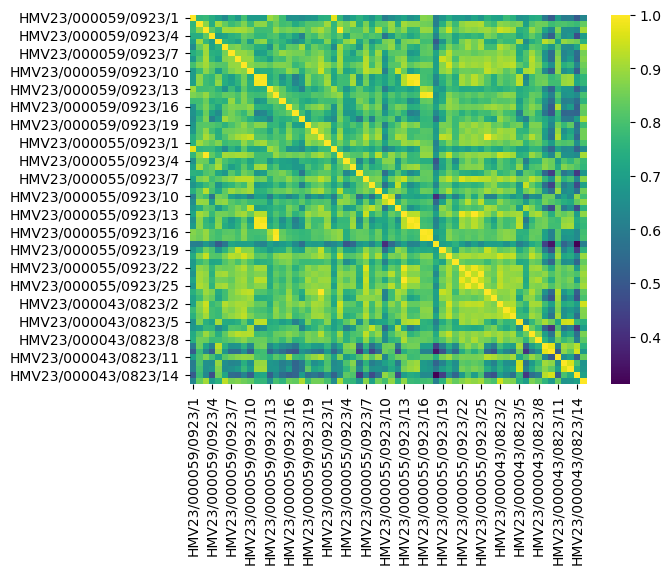

In [24]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_description_df, cmap='viridis')
plt.show()

In [25]:
cosine_sim_description_df.to_csv('./similarityMatrixFiles/cos_sim_description.csv', index=True)

### Similarity Matrix for "Corrective Measure"

In [26]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['corrective_action_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['corrective_action_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['corrective_action_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [27]:
df_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_correction

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.788351,-0.818996,-0.630261,-0.727544,-0.717193,-0.496929,-0.808907,-0.512398,-0.723586,-0.46956,...,-0.410593,-0.679378,-0.887238,-0.707964,-0.643426,-0.679615,-0.504287,-0.571588,-0.647734,-0.530129
1,-0.484558,-0.536668,-0.567799,-0.586891,-0.617948,-0.531382,-0.560408,-0.481845,-0.527002,-0.577328,...,-0.569525,-0.430323,0.045907,-0.818367,-0.657298,-0.67521,-0.806563,-0.798257,-0.579416,-0.429291
2,0.053019,0.209987,0.334021,0.393437,0.643868,0.176591,0.204325,0.142865,0.255765,0.19757,...,0.21446,0.300454,-0.071734,0.455576,0.343302,0.502974,0.898194,0.53625,0.210073,0.068359
3,0.286135,0.475425,0.639083,0.385343,0.576545,0.507846,0.621222,0.548663,0.550013,0.42403,...,0.526436,0.593985,0.329493,0.319828,0.363152,0.227212,0.319111,0.212804,0.416104,0.555915
4,0.869403,1.173708,1.037856,0.981595,1.455833,0.78165,1.245592,0.945396,1.054821,0.800498,...,0.782686,1.061776,-0.06446,1.074961,1.218442,0.865548,0.891448,0.968591,0.790636,0.834961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.197221,-0.129722,0.027491,0.23597,0.268289,-0.008688,-0.090512,0.132056,0.052635,0.026296,...,0.062023,0.128548,-0.370823,0.343414,0.110377,0.426963,0.550541,0.302011,-0.076053,-0.215036
92,0.695078,0.662038,0.549248,0.765284,0.022875,0.738144,0.291611,0.673858,0.560503,0.769905,...,0.735802,0.530089,1.729075,0.55466,0.553487,0.696028,0.480322,0.55852,0.843266,0.710886
93,0.243106,0.220029,0.164436,-0.048681,0.058354,0.252979,0.155041,0.202399,0.106107,0.192751,...,0.203173,0.197783,0.316275,0.060786,0.160082,-0.017196,-0.008902,0.018914,0.171998,0.21677
94,0.139806,-0.105967,-0.21675,-0.084573,-0.396006,-0.106495,-0.236569,-0.195299,-0.279886,-0.208051,...,-0.109119,-0.338151,0.273594,-0.13219,-0.19546,-0.158799,-0.274424,-0.142775,-0.070044,-0.153335


In [28]:
cos_sim_correction_mat = cosine_similarity(df_correction.T)
cosine_sim_correction_df = pd.DataFrame(cos_sim_correction_mat, index=df_correction.columns, columns=df_correction.columns)

In [29]:
cosine_sim_correction_df.to_csv('./similarityMatrixFiles/cos_sim_correction.csv', index=True)

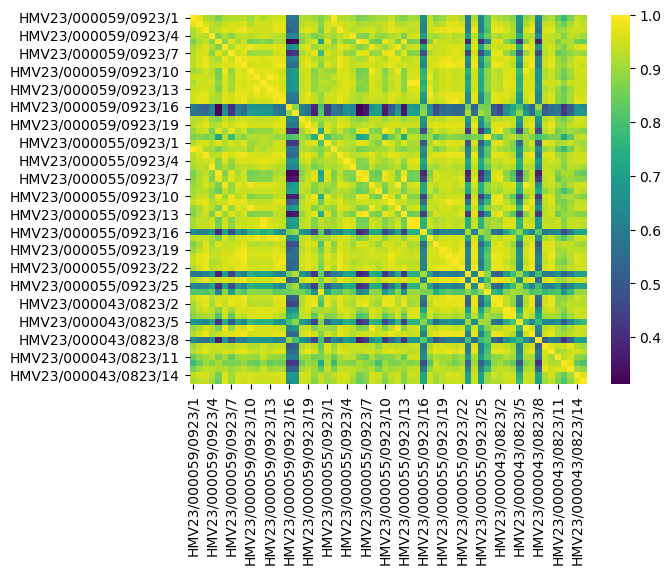

In [30]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_correction_df, cmap='viridis')
plt.show()

### Similarity Matrix for "Description + Corrective Measure"

In [31]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['description_correction_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['description_correction_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['description_correction_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [32]:
df_desc_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_desc_correction

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.713789,-0.780711,-0.615419,-0.603613,-0.647318,-0.52071,-0.744721,-0.435015,-0.698631,-0.435264,...,-0.409873,-0.591126,-0.498638,-0.555908,-0.554938,-0.613789,-0.418666,-0.412803,-0.704442,-0.500549
1,-0.319262,-0.45288,-0.41884,-0.499884,-0.551189,-0.477768,-0.513817,-0.416334,-0.503269,-0.547996,...,-0.495139,-0.412298,-0.168815,-0.747437,-0.676472,-0.634277,-0.817925,-0.77514,-0.647116,-0.368914
2,0.07785,0.183043,0.18454,0.327409,0.592923,0.058333,0.159985,-0.023087,0.208309,0.045369,...,0.031064,0.220489,-0.065371,0.50278,0.439477,0.380264,0.769589,0.513394,0.229867,-0.090585
3,0.130941,0.432427,0.569074,0.44293,0.43027,0.500974,0.575999,0.477546,0.475121,0.415431,...,0.443331,0.543668,0.353886,0.267545,0.354498,0.243168,0.300456,0.203997,0.371975,0.545417
4,0.648897,0.997607,0.871439,0.889599,1.15528,0.681657,1.058557,0.74537,0.895056,0.623878,...,0.60377,0.942563,0.076634,0.98681,1.141203,0.7106,0.787684,0.770469,0.885928,0.626602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.141895,-0.100157,-0.078664,0.296721,0.276959,-0.097333,-0.111899,0.059816,0.06464,-0.030784,...,0.113352,0.099598,-0.094911,0.303605,0.223337,0.297655,0.572441,0.385247,0.043273,-0.367131
92,0.882572,0.788844,0.761253,0.928192,0.254169,0.834337,0.419876,0.916248,0.672749,1.034118,...,0.926676,0.719978,1.369942,0.645836,0.573794,0.867134,0.698676,0.822439,0.665824,0.890731
93,0.177602,0.212255,0.224877,-0.075813,0.082606,0.310665,0.183449,0.225913,0.118386,0.207212,...,0.22397,0.18024,0.341858,0.072512,0.114377,-0.001792,-0.037548,0.025043,0.165743,0.307982
94,0.287388,-0.133318,-0.082639,0.024693,-0.317825,-0.022807,-0.156958,-0.10118,-0.227553,-0.098295,...,-0.101772,-0.235517,-0.007036,-0.146327,-0.223821,-0.172539,-0.197629,-0.219478,-0.056765,-0.058037


In [33]:
cos_sim_desc_correction_mat = cosine_similarity(df_desc_correction.T)
cosine_sim_desc_correction_df = pd.DataFrame(cos_sim_desc_correction_mat, index=df_desc_correction.columns, columns=df_desc_correction.columns)

In [34]:
cosine_sim_desc_correction_df.to_csv('./similarityMatrixFiles/cos_sim_desc_correction.csv', index=True)

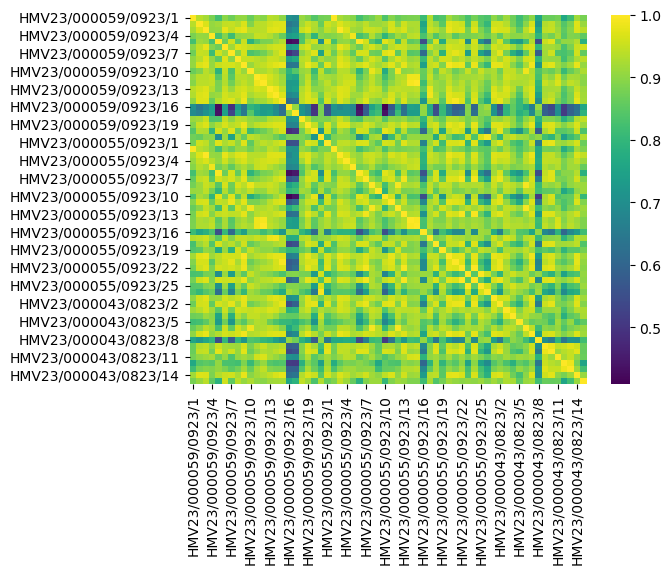

In [35]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_desc_correction_df, cmap='viridis')
plt.show()